Mount Drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install catboost
! pip install shap

     |████████████████████████████████| 76.3 MB 26 kB/s 
     |████████████████████████████████| 371 kB 28.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509234 sha256=04fc283da189f31d34db3a0e3f31053c11cc7e8a191d2c031b088eff25e4009d
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


Cat-Boost Meta-Learner 

In [ ]:
import time
import datetime
from math import sqrt
import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas
import sklearn.metrics as metrics
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from numpy import asarray, hstack, vstack
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import pandas as pd
import keras 
import tensorflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import catboost as cb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  
bwd_feat = pd.read_csv('./drive/MyDrive/BorutaShap/bwd_feat.csv')['Feat']
bor_feat = pd.read_csv('./drive/MyDrive/BorutaShap/borutashap.csv')['feat']
knn_feat = pd.read_csv('./drive/MyDrive/BorutaShap/knn_step.csv')['feat']
step_feat = pd.read_csv('./drive/MyDrive/BorutaShap/step_feat.csv')['Feat']
get_bwd_data = FunctionTransformer(lambda x: x[bwd_feat.values], validate=False)
get_bor_data = FunctionTransformer(lambda x: x[bor_feat.values], validate=False)
get_knn_data = FunctionTransformer(lambda x: x[knn_feat.values], validate=False)


def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,39))
    for name, model in get_models(cat_features=None):
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results['Meta'] =  np.sqrt(mean_squared_error(df['total_points'], df['Meta']))
    results.drop_duplicates(inplace = True)
    results['Best'] = results.idxmin(axis=1)
    results['BestRSME'] = results.min(axis=1)
    return results.round(3)

def split_dfs(df, GW, szn = 2020, idx = False):
    X_test = df[(df['season'] == szn) & (df['GW'] == GW)]
    y_test = X_test['total_points']
    X_train = df[df['kickoff_time'] < X_test['kickoff_time'].min()]
    y_train = X_train['total_points']
    if idx == True:
        idxrs_test = X_test[['player_name', 'kickoff_time', 'GW', 'season']]
        X_test.drop(DROP_COLS, axis = 1, inplace = True), X_train.drop(DROP_COLS, axis = 1, inplace = True) 
        return X_train, X_test, y_train, y_test, idxrs_test
    else:
        # Removes kickoff time, gameweek, season and total points
        X_test.drop(DROP_COLS, axis = 1, inplace = True), X_train.drop(DROP_COLS, axis = 1, inplace = True) 
        return X_train, X_test, y_train, y_test


def get_training_data(GW, df, df_encoded, X_oof_train, std_x, std_y): 
    if GW == 1:
        # Get, sort and round numerical precision..
        df =  pd.read_csv('/content/drive/MyDrive/Data/rollbacked_us_testing.csv').round(8).sort_values(by = ['season', 'GW', 'player_name', 'kickoff_time'])
        X_oof_train = pd.read_csv('./drive/MyDrive/Predictions/unrounded_oof_predictions_10.csv').round(8)
        df = df[df['season'] < 2021] # Predict for /21 
        # Encode cats
        df_encoded = encode_categoricals(df)
        # Scale data
        for data in [df_encoded, df]:
            scaled_cols, error_cols, std_x, std_y = [], [], StandardScaler(), StandardScaler()
            for col in data.select_dtypes(include = 'number').drop([col1 for col1 in DROP_COLS if col1 in data.select_dtypes(include = 'number').columns], axis = 1).columns:
                if data[col].nunique() > 2:
                    scaled_cols.append(col)
                if data[col].min() < 1e-7:
                    error_cols.append(col)
            data[scaled_cols] = std_x.fit_transform(data[scaled_cols])
            data['total_points'] = std_y.fit_transform(data['total_points'].to_numpy().reshape(-1, 1))

        X_oof_train[scaled_cols] = std_x.transform(X_oof_train[scaled_cols])
        X_oof_train.drop(DROP_COLS, axis = 1, inplace = True)
        for name, _ in get_models():
            X_oof_train[name] = std_y.transform(X_oof_train[name].to_numpy().reshape(-1, 1))
    else:
        pass 
      
  
    # Construct data for CBoost base + get indexers
    X_train, X_test, y_train, y_test, idxrs_test = split_dfs(df, GW, idx = True) 

    # Construct data for other base learners
    X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = split_dfs(df_encoded, GW) # Does not contain player name

    return X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, df, df_encoded, std_x, std_y, X_oof_train, idxrs_test

def encode_categoricals(df):
    # Any model that needs numerical preprocessing cannot use the name feature
    encode_df = df.drop(columns = ['player_name'], axis = 1)
    # Encode booleans
    for col in encode_df.columns:
      if pd.api.types.is_bool_dtype(encode_df[col]):
        encode_df[col] = encode_df[col].replace({True:1, False:0})
    # One hot encode 
    encode_df = pd.get_dummies(encode_df, columns=OHE_COLS, prefix=OHE_COLS)
    # Ordinal encoding
    mapping = {'Low': 0, 'Medium': 0.5, 'Hard':1}
    encode_df['FDR'] = encode_df['FDR'].map(lambda x : mapping[x])
    return encode_df

def get_models(cat_features = None):

    models = list()
    # Linear Regression
    models.append(('LR', Pipeline([('selector', get_bwd_data), ('LR', LinearRegression())]))) # Done
    # CatBoost
    models.append(('CBoost', Pipeline([('CBoost', cb.CatBoostRegressor(loss_function='RMSE', cat_features = cat_features,
                                                                       task_type=TASK_TYPE, logging_level='Silent', depth = 6,
                                                                       l2_leaf_reg = 1, learning_rate = 0.03,
                                                                       bagging_temperature = 0.1, iterations = ITERATIONS))]))) 
    # SVR
    models.append(('SVR', Pipeline([('selector', get_bor_data), ('SVR', SVR(C=6, cache_size=200, coef0=0.0, degree=3, epsilon=0.6, gamma=0.005, 
                                                                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]))) 
    # KNN
    models.append(('KNN', Pipeline([('selector', get_knn_data), ('KNN', KNeighborsRegressor(algorithm='kd_tree', leaf_size=1, metric='manhattan',
                                                                                            metric_params=None, n_jobs=8, n_neighbors=86, p=2,
                                                                                            weights='distance'))]))) 
    # Neural Network
    models.append(('MLP', Pipeline([('selector', get_bor_data), ('MLP', MLPRegressor(activation='identity', alpha=1e-05, batch_size=16, beta_1=0.9,
                                                                                     beta_2=0.999, early_stopping=True, epsilon=1e-07,
                                                                                     hidden_layer_sizes=(64, 128), learning_rate='constant',
                                                                                     learning_rate_init=0.0001, max_fun=15000, max_iter=50,
                                                                                     momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                                                                                     power_t=0.5, random_state=0, shuffle=True, solver='adam',
                                                                                     tol=1e-08, validation_fraction=0.1, verbose=False,
                                                                                     warm_start=False))])))  
    return models



def get_out_of_fold_predictions(GW, X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, models):
    meta_X, meta_y, y_index, fold_yhats = list(), list(), list(), list()
    # Store folds
    meta_y.extend(y_test)
    y_index = y_test.index
    # Encode categorical features for base learners' 
    # Get validation predictions of all base learners
    for name, model in models:
        start = time.time()
        if name in ['CBoost']:
            X_train_base, X_test_base = X_train, X_test
            if EARLY_STOPPING:
                X_train_es, X_val, y_train_es, y_val = train_test_split(X_train_base, y_train, test_size=0.1, random_state=1)
                model.fit(X_train_es, y_train_es, CBoost__early_stopping_rounds = 100, CBoost__eval_set = [(X_test_base, y_test)])
            else:
                 model.fit(X_train_base, y_train)
        else:
            X_train_base, X_test_base = X_train_encoded, X_test_encoded
            model.fit(X_train_base, y_train)  

        # Get base learners' predictions
        yhat = model.predict(X_test_base)  
        fold_yhats.append(yhat.reshape(len(yhat), 1)) 
        # Profile model
        if VERBOSE:
            print(f'{GW}: {name}: {round(time.time()-start,3)} seconds') 
    # Store base learner predictions as columns
    meta_X.append(hstack(fold_yhats)) 
    # Scaled out-of-fold predictions of base learners
    y_oof_true = pd.DataFrame(asarray(meta_y), index=y_index)
    X_oof_preds = pd.DataFrame(vstack(meta_X), columns = [name for name, _ in models], index=y_index)
    return X_oof_preds, y_oof_true, y_index 
    

def construct_oof_data(GW, X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, X_oof_train):
    if not PROPAGATE:
      X_train.drop(['team', 'opponent_team', 'player_name'], axis = 1, inplace = True)
      X_test.drop(['team', 'opponent_team', 'player_name'], axis = 1, inplace = True)
    # Categorical features in level-0 training set
    cat_features_train = np.where(X_train.dtypes == 'object')[0] 
    # Base learners 
    models = get_models(cat_features_train) 
    # Get base learners OOF preds
    X_oof_preds, y_oof_true, y_index = get_out_of_fold_predictions(GW, X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, models) 
    # Construct propagated level-1 test set
    X_oof_test = pd.merge(X_oof_preds, X_test, left_index=True, right_index=True) 
    X_oof_test.to_csv(f'/content/drive/MyDrive/Predictions/{GW}_oof.csv', index = False)
    # Categorical features in level-1 testing set
    # Concatenate new data to training data
    if GW > 1:
        X_oof_train = pd.concat([X_oof_train, pd.read_csv(f'/content/drive/MyDrive/Predictions/{GW - 1}_oof.csv')])
    X_oof_train = X_oof_train[X_oof_test.columns]
    return X_oof_test, y_oof_true, cat_features_train,  models, X_oof_train


def fit_meta_model(GW, X_oof_train, y_oof_train, X_oof_test, y_oof_true): 
    start = time.time()
    model =  cb.CatBoostRegressor(cat_features =  np.where(X_oof_train.dtypes == 'object')[0], task_type=TASK_TYPE,
                                  depth = 8, 
                                  iterations = ITERATIONS,
                                  l2_leaf_reg = 1,
                                  learning_rate = 0.03, 
                                  logging_level = 'Silent') # Test: Can early stopping improve performance?
    if EARLY_STOPPING:
        X_train, X_val, y_train, y_val = train_test_split(X_oof_train, y_oof_train, test_size=0.1, random_state=1)
        model.fit(X_train, y_train, early_stopping_rounds = 100, eval_set = [(X_val, y_val)])
    else:
        model.fit(X_oof_train, y_oof_train)
    print(f'{GW}: Meta: {round(time.time()-start,3)} seconds') 
    return model

def main():
    # For all gameweeks
    for GW in list(range(1,39)):
        if not VERBOSE:
            print(GW)
        if GW == 1:
            results, df, df_encoded, std_x, std_y, X_oof_train = [], [], [], [], [], []
        else:
            pass
        # Level-0 training + testing sets
        X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, df, df_encoded, std_x, std_y, X_oof_train, idxrs_test = get_training_data(GW, df, df_encoded, X_oof_train, std_x, std_y)
        # Construct level-1 training + testing sets
        X_oof_test, y_oof_true, cat_features_train,  models, X_oof_train = construct_oof_data(GW, X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, X_oof_train)
        # Fit meta-learner on level-1 training set
        meta_model = fit_meta_model(GW, X_oof_train, y_train, X_oof_test, y_oof_true) 
        # Predict using meta_model
        meta_preds = meta_model.predict(X_oof_test)

        # # Check shaps
        # explainer = shap.TreeExplainer(meta_model)
        # shap_values = explainer.shap_values(X_oof_test)
        # shap.summary_plot(shap_values, X_oof_test, show = False)
        # plt.savefig('./drive/MyDrive/figs/shap_test_meta.pdf', bbox_inches = 'tight')

        # Print weekly RMSE
        if VERBOSE:
            print(f'{GW} : Meta-learner : RMSE = {sqrt(mean_squared_error(np.round(std_y.inverse_transform(y_test)), np.round(std_y.inverse_transform(meta_preds))))}')
            for name, _ in models:
                print(f'{GW} : {name} : RMSE = {sqrt(mean_squared_error(np.round(std_y.inverse_transform(y_test)), np.round(std_y.inverse_transform(X_oof_test[name]))))}')
        # Should response be rounded
        if ROUND:
            for name, _ in models:
                idxrs_test[name] = np.round(std_y.inverse_transform(X_oof_test[name]))
            idxrs_test['Meta'] = np.round(std_y.inverse_transform(meta_preds))
        else: 
            for name, _ in models:
                idxrs_test[name] = std_y.inverse_transform(X_oof_test[name])
            idxrs_test['Meta'] = std_y.inverse_transform(meta_preds)
        # Save weekly results
        results.append(idxrs_test)
    # Concatenate all predictions
    df_preds = pd.concat(results).reset_index(drop=True)    
    # Save the results with the original player name
    # df = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv')[['player_name', 'position', 'team', 'value', 'kickoff_time', 'total_points']]
    # df = df[df['kickoff_time'] > '2020-08-12'] # Predicted for the /21 season
    # df_preds = pd.merge(df_preds, df, on = ['player_name', 'kickoff_time'], how = 'inner')
    df_preds.to_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv', index = False)
    # Use the previous gameweek testing results as early stopping criterion





# Test parameters
N_SPLITS = 10
TASK_TYPE = 'CPU' # GPU is giving inconsistent results
ITERATIONS = 1000 
VERBOSE = True
PROPAGATE = True # Player name, team and opponent team features
ROUND = False
EARLY_STOPPING = True
OHE_COLS =  ['team', 'position', 'opponent_team', 'position_location', 'premium_players']
DROP_COLS = ['kickoff_time', 'total_points', 'GW', 'season']
# main()

In [ ]:
df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv')
df_correct = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(['season', 'GW', 'player_name',  'kickoff_time'])
df_correct = df_correct[df_correct['season'] == 2020]
df_correct.reset_index(drop = True, inplace = True)
df_correct['H2O'] = df_results['automl'].values

,player_name,kickoff_time,GW,season,LR,CBoost,SVR,KNN,MLP,Meta
0,Aaron Connolly,2020-09-14,1,2020,1.170578,1.613324,3.223093,3.149316,2.061467,2.835205
1,Aaron Cresswell,2020-09-12,1,2020,2.163982,3.263234,2.875090,2.798591,3.235438,2.910930
2,Aaron Ramsdale,2020-09-14,1,2020,1.753843,3.815019,3.844155,3.171717,3.065320,2.908770
3,Abdoulaye Doucouré,2020-09-13,1,2020,0.596630,3.318724,3.100850,2.682273,2.589561,2.810104
4,Aboubakar Kamara,2020-09-12,1,2020,2.612433,2.346020,2.739583,1.807111,2.785375,2.936902
...,...,...,...,...,...,...,...,...,...,...
10424,Willian José Da Silva,2021-05-23,38,2020,1.461409,1.750808,2.386834,1.612086,1.618549,1.914618
10425,Willy Boly,2021-05-23,38,2020,2.724923,3.192019,2.550103,2.747661,2.802891,2.834726
10426,Youri Tielemans,2021-05-23,38,2020,2.978103,2.547918,3.338898,2.927123,3.503087,2.878180
10427,Yves Bissouma,2021-05-23,38,2020,2.094588,2.247594,2.684218,2.296442,2.754506,2.569465


In [ ]:
pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_train.csv')

,player_name,kickoff_time,GW,season,total_points,LR,CBoost,SVR,KNN,MLP,Meta
0,Aaron Cresswell,2019-08-10,1,2019,0.0,1.0,1.0,2.0,1.0,1.0,3.0
1,Aaron Lennon,2019-08-10,1,2019,1.0,3.0,4.0,3.0,3.0,3.0,3.0
2,Aaron Ramsdale,2019-08-10,1,2019,2.0,3.0,3.0,3.0,2.0,3.0,3.0
3,Aaron Wan-Bissaka,2019-08-11,1,2019,8.0,3.0,4.0,3.0,2.0,3.0,3.0
4,Abdoulaye Doucouré,2019-08-10,1,2019,0.0,5.0,5.0,4.0,3.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
10653,William Smallbone,2020-07-26,38,2019,7.0,3.0,1.0,3.0,3.0,3.0,3.0
10654,Willy Boly,2020-07-26,38,2019,1.0,1.0,1.0,2.0,1.0,1.0,3.0
10655,Willy Caballero,2020-07-26,38,2019,6.0,3.0,3.0,3.0,2.0,3.0,3.0
10656,Youri Tielemans,2020-07-26,38,2019,2.0,0.0,1.0,2.0,1.0,1.0,3.0


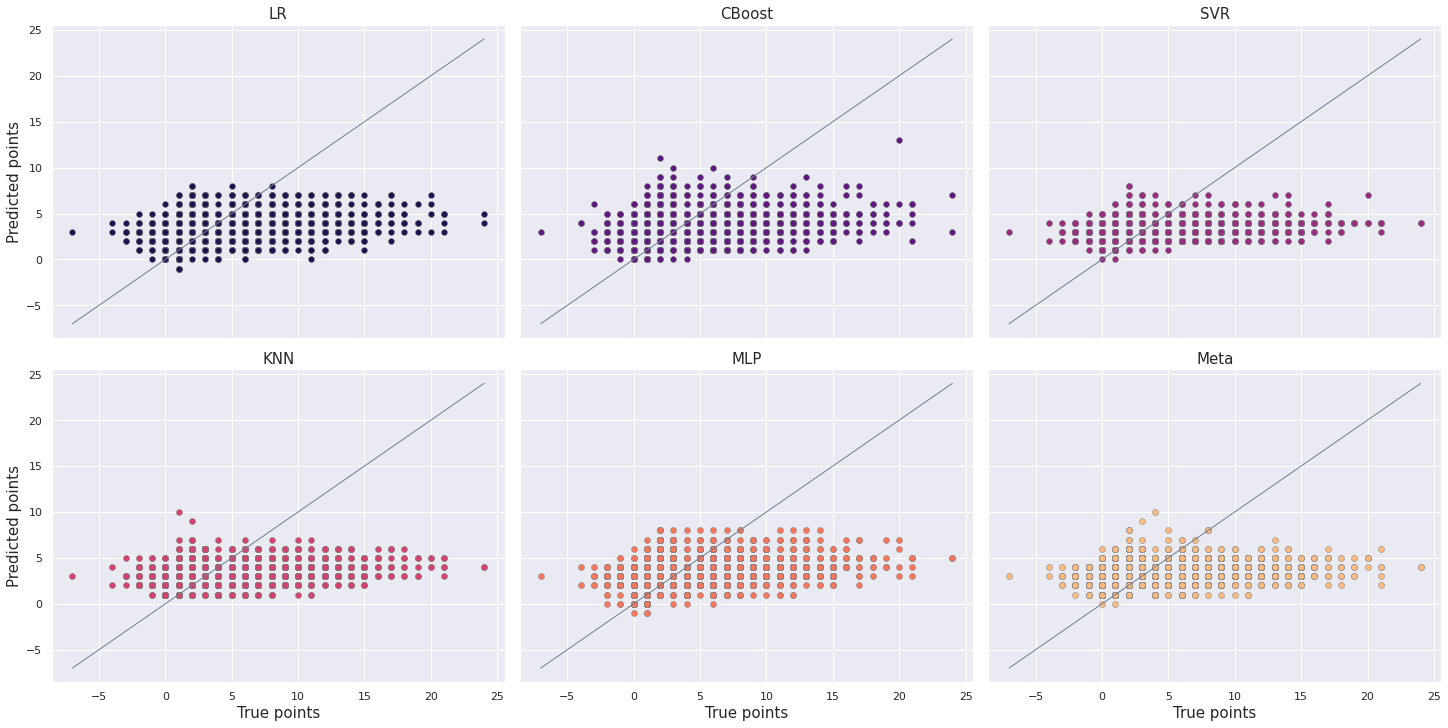

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib 
def plot_results(true_value, predicted_value, title, ax):
    plt.figure(figsize=(10,10))
    ax.scatter(true_value, predicted_value, edgecolors=(0, 0, 0), c = 'crimson')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    ax.plot([p1, p2], [p1, p2], 'k--', lw=4)
    plt.xlabel('True points', fontsize=15)
    plt.ylabel('Predicted points', fontsize=15)
    plt.title(title)
    plt.axis('equal')
# df[df['position'] == 'FWD']
df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_train.csv')


# %%
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows = 2, sharey=True, sharex = True, figsize = (20, 10),  constrained_layout = True)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')
if 'meta' in df.columns:
    df['Meta'] = df['meta']
i = 0
for name, ax in list(zip(['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta'], axs)):
    sns.scatterplot(x = 'total_points', y = name, data = df, ax = ax, edgecolor = 'gray', color = matplotlib.colors.to_hex(sns.color_palette('magma', 6)[i]))
    ax.set_title(name,fontsize=15)
    ax.set_xlabel('True points',fontsize=15)
    ax.set_ylabel('Predicted points', fontsize=15)
    p1 = max(max(df[name]), max(df['total_points']))
    p2 = min(min(df[name]), min(df['total_points']))
    ax.plot([p1, p2], [p1, p2], lw=1, c = 'slategray')
    i += 1
plt.savefig('/content/drive/MyDrive/figs/testing_preds.png', bbox_inches='tight') 




Training regression metrics

In [ ]:
def regression_metrics(y_true, y_pred, name):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    return pd.DataFrame({"MAE":[mean_absolute_error], 'R2':[r2],
                         "MSE": [mse],
                         "RMSE":[np.sqrt(mse)]}, index = [name]).T.round(3)
# print(regression_metrics(df['total_points'], df['automl'], 'automl').to_latex())

# df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')
# df_base['avg_base_preds'] = 0
# for name, model in get_models(cat_features=None):
#       df_base['avg_base_preds'] += df_base[name]/5


# df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/other_metas.csv')
# df_preds['avg_meta_preds'] = 0
# for name, model in get_meta_models(cat_features=None):
#       df_preds['avg_meta_preds'] += df_preds[name]/5

# df_preds['avg_meta_preds'] = np.round(df_preds['avg_meta_preds'])
# df_preds['avg_base_preds'] = np.round(df_base['avg_base_preds'])
# df = df_preds

# def gameweek_rmses(df):
#     results = pd.DataFrame(index = np.arange(1,39))
#     results['automl'] = np.sqrt(mean_squared_error(df['total_points'], df['automl']))
#     results.drop_duplicates(inplace = True)
#     return results.round(3)

# df = pd.read_csv('/content/drive/MyDrive/Predictions/h2o_export/h2o_results.csv')
# results = df.groupby('GW').apply(gameweek_rmses).reset_index()
# print(results.append(results.sum().rename('Total')).to_latex())
# print(regression_metrics(df['total_points'], df['automl'], 'automl').to_latex())

# df = pd.read_csv('/content/drive/MyDrive/Predictions/empty_stadium_performance.csv')
# df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_with_prop_and_early_stop.csv')
# df = df[df['season'] == 2020]
# df = df[df['GW'] < 8]
# results = df.groupby('GW').apply(gameweek_rmses).reset_index()
# print(results.append(results.sum().rename('Total')).to_latex())

df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_train.csv')
# df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')



results = []
for name in ['LR',   'CBoost', 'SVR','KNN', 'MLP', 'Meta']:
    results.append(regression_metrics(df['total_points'], df[name], name))
print(pd.concat(results, axis = 1).to_latex())


\begin{tabular}{lrrrrrr}
\toprule
{} &      LR &  CBoost &    SVR &    KNN &     MLP &   Meta \\
\midrule
MAE  &   2.366 &   2.391 &  2.287 &  2.269 &   2.348 &  1.973 \\
R2   &  -0.187 &  -0.244 & -0.085 & -0.135 &  -0.174 &  0.202 \\
MSE  &  10.420 &  10.918 &  9.520 &  9.958 &  10.302 &  7.003 \\
RMSE &   3.228 &   3.304 &  3.085 &  3.156 &   3.210 &  2.646 \\
\bottomrule
\end{tabular}



CatBoost Meta Learner with propagation (> 80 min)

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')
# df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_train.csv')
#  LR &   CBoost &      SVR &      KNN &      MLP &     Meta &                                               Best &  BestRSME \\

# Total &  741 &       38 &  106.521 &  105.146 &  107.434 &  107.053 &  106.357 &  108.011 &  CBoostLRKNNSVRCBoostCBoostCBoostCBoostMLPLRLRC... &   104.638 \\
# Total &  741 &       38 &  106.954 &  105.731 &  108.202 &  107.678 &  106.838 &  107.520 &  CBoostLRKNNMLPMLPCBoostCBoostCBoostCBoostCBoos... &   104.943 \\
# Total &  741 &       38 &  106.954 &  107.917 &  108.202 &  107.678 &  106.838 &  108.348 &  CBoostLRKNNMLPMLPMLPCBoostKNNMLPLRLRSVRLRLRLRK... &   105.404 \\

df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding.csv')
results = df.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
print("Total season performance")
for name in ['LR', 'KNN', 'MLP', 'SVR', 'CBoost', 'Meta']:
    print(f'{name} : {np.sqrt(mean_squared_error(df.total_points, df[name]))}')

NameError: ignored

CatBoost Meta Learner with propagation and early stopping (~ 20 min)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_with_prop_and_early_stop.csv')

def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,8))
    for name, model in get_models(cat_features=None):
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results['Meta'] =  np.sqrt(mean_squared_error(df['total_points'], df['Meta']))
    results.drop_duplicates(inplace = True)
    results['Best'] = results.idxmin(axis=1)
    results['BestRSME'] = results.min(axis=1)
    return results.round(3)
df = df[df['GW'] < 8]
results = df.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
print("Total season performance")
for name in ['LR', 'KNN', 'MLP', 'SVR', 'CBoost', 'Meta']:
    print(f'{name} : {np.sqrt(mean_squared_error(df.total_points, df[name]))}')

\begin{tabular}{lrrrrrrrrlr}
\toprule
{} &  GW &  level\_1 &      LR &  CBoost &     SVR &     KNN &     MLP &    Meta &                           Best &  BestRSME \\
\midrule
0     &   1 &        1 &   3.356 &   3.056 &   3.172 &   3.312 &   3.169 &   3.321 &                         CBoost &     3.056 \\
1     &   2 &        1 &   3.505 &   3.563 &   3.653 &   3.611 &   3.554 &   3.760 &                             LR &     3.505 \\
2     &   3 &        1 &   2.970 &   2.928 &   2.939 &   2.902 &   2.939 &   2.906 &                            KNN &     2.902 \\
3     &   4 &        1 &   3.727 &   3.691 &   3.632 &   3.698 &   3.618 &   3.745 &                            MLP &     3.618 \\
4     &   5 &        1 &   2.635 &   2.639 &   2.779 &   2.653 &   2.628 &   2.762 &                            MLP &     2.628 \\
5     &   6 &        1 &   2.586 &   2.538 &   2.653 &   2.605 &   2.566 &   2.580 &                         CBoost &     2.538 \\
6     &   7 &        1 &   2.910 &   2

CatBoost Meta-Learner with prop (wiuth the player name, team, and opponent team features removed) and with early stopping

In [ ]:
df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv')
df_correct = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(['season', 'GW', 'player_name',  'kickoff_time'])
df_correct = df_correct[df_correct['season'] == 2020]
df_correct.reset_index(drop = True, inplace = True)
df_preds[['total_points', 'team', 'position']] = df_correct[['total_points', 'team', 'position']]

results = df_preds.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
print("Total season performance")
for name in ['LR', 'KNN', 'MLP', 'SVR', 'CBoost', 'Meta']:
    print(f'{name} : {np.sqrt(mean_squared_error(df_preds.total_points, df_preds[name]))}')

\begin{tabular}{lrrrrrrrrlr}
\toprule
{} &   GW &  level\_1 &       LR &   CBoost &      SVR &      KNN &      MLP &     Meta &                                               Best &  BestRSME \\
\midrule
0     &    1 &        1 &    3.365 &    3.041 &    3.191 &    3.258 &    3.171 &    3.330 &                                             CBoost &     3.041 \\
1     &    2 &        1 &    3.522 &    3.545 &    3.626 &    3.584 &    3.535 &    3.807 &                                                 LR &     3.522 \\
2     &    3 &        1 &    2.954 &    2.931 &    2.913 &    2.866 &    2.912 &    2.975 &                                                KNN &     2.866 \\
3     &    4 &        1 &    3.715 &    3.666 &    3.622 &    3.673 &    3.631 &    3.726 &                                                SVR &     3.622 \\
4     &    5 &        1 &    2.635 &    2.631 &    2.748 &    2.651 &    2.621 &    2.818 &                                                MLP &     2.621 \\
5     &

Other learners-performance as meta-learners

In [ ]:
def get_meta_models(cat_features = None):

    models = list()
    # Linear Regression
    models.append(('LR', Pipeline([('LR', LinearRegression())]))) 
    # CatBoost
    models.append(('CBoost', Pipeline([('CBoost', cb.CatBoostRegressor(loss_function='RMSE', cat_features = cat_features,
                                                                       task_type=TASK_TYPE, logging_level='Silent', depth = 2,
                                                                       l2_leaf_reg = 3, learning_rate = 0.03,
                                                                       bagging_temperature = 0.1, iterations = ITERATIONS))]))) 
    # SVR
    models.append(('SVR', Pipeline([('SVR', SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.6, gamma=0.005,
                                               kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])))  
    
    # KNN
    models.append(('KNN', Pipeline([('KNN', KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, metric='euclidean',
                                                                metric_params=None, n_jobs=8, n_neighbors=300, p=2,
                                                                weights='uniform'))]))) 
    # Neural Network
    models.append(('MLP', Pipeline([('MLP', MLPRegressor(activation='relu', alpha=0, batch_size=16, beta_1=0.9,
                                                         beta_2=0.999, early_stopping=True, epsilon=1e-07,
                                                         hidden_layer_sizes=(128, 256), learning_rate='constant',
                                                         learning_rate_init=0.0001, max_fun=15000, max_iter=20,
                                                         momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                                                         power_t=0.5, random_state=0, shuffle=True, solver='adam',
                                                         tol=1e-08, validation_fraction=0.1, verbose=False,
                                                         warm_start=False))])))  
    return models

def meta_preds(GW, X_oof_train, y_oof_train, X_oof_test, y_oof_test): 
    preds, fold_yhats = list(), list()
    for name, model in get_meta_models():
        start = time.time()
        model.fit(X_oof_train, y_oof_train)
        yhat = model.predict(X_oof_test)  
        fold_yhats.append(yhat.reshape(len(yhat), 1)) 
        print(f'{GW}: Meta: {round(time.time()-start,3)} seconds') 
    preds.append(hstack(fold_yhats)) 
    preds = pd.DataFrame(vstack(preds), columns = [name for name, _ in get_meta_models()])
    return preds

def quick_level_1(GW):  
    # Separate training and testing
    df_train = pd.read_csv('./drive/MyDrive/Predictions/oof_predictions_10.csv')
    df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')
    std_x, std_y = StandardScaler(), StandardScaler()
    df_concat_train = df_preds[df_preds['GW'] < GW]
    df_test = df_preds[df_preds['GW'] == GW]  
    # Predictors
    X_oof_train  = std_x.fit_transform(pd.concat([df_train[[name for name, _ in get_meta_models()]], 
                                                  df_concat_train[[name for name, _ in get_meta_models()]]]))
    X_oof_test  = std_x.transform(df_test[[name for name, _ in get_meta_models()]])
    
    # Response
    y_oof_train = std_y.fit_transform(pd.concat([df_train['total_points'], 
                                                 df_concat_train['total_points']]).to_numpy().reshape(-1, 1))
    y_oof_test = std_y.fit_transform(df_test['total_points'].to_numpy().reshape(-1, 1))
    # Keep track of players and gameweeks
    test_idx = df_test[['player_name', 'kickoff_time', 'GW', 'season']]
    return X_oof_train, y_oof_train, X_oof_test, y_oof_test, test_idx, std_y

def main():
    # For all gameweeks
    results = []
    for GW in list(range(1,39)):
        # Get level-1 data set
        X_oof_train, y_oof_train, X_oof_test, y_oof_test, idxrs_test, std_y = quick_level_1(GW)
        # Get three models predictions
        meta_predictions = meta_preds(GW, X_oof_train, y_oof_train, X_oof_test, y_oof_test)
        # Save weekly results
        for name, _ in get_meta_models():
            idxrs_test[name] = std_y.inverse_transform(meta_predictions[name].to_numpy().reshape(-1, 1))
        # Indexers + results
        idxrs_test['total_points'] = std_y.inverse_transform(y_oof_test)
        results.append(idxrs_test)
    # Concat all preds
    df_preds = pd.concat(results).reset_index(drop=True)    
    df_preds.to_csv('/content/drive/MyDrive/Predictions/other_metas.csv', index = False)
main()


1: Meta: 0.015 seconds
1: Meta: 0.983 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


1: Meta: 3.644 seconds
1: Meta: 0.134 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


1: Meta: 14.805 seconds
2: Meta: 0.002 seconds
2: Meta: 0.903 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


2: Meta: 3.404 seconds
2: Meta: 0.133 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


2: Meta: 12.801 seconds
3: Meta: 0.001 seconds
3: Meta: 0.943 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


3: Meta: 3.55 seconds
3: Meta: 0.132 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


3: Meta: 11.672 seconds
4: Meta: 0.002 seconds
4: Meta: 0.931 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


4: Meta: 3.665 seconds
4: Meta: 0.134 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


4: Meta: 15.422 seconds
5: Meta: 0.002 seconds
5: Meta: 0.944 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


5: Meta: 3.914 seconds
5: Meta: 0.138 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


5: Meta: 16.228 seconds
6: Meta: 0.002 seconds
6: Meta: 0.938 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


6: Meta: 4.164 seconds
6: Meta: 0.138 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


6: Meta: 16.101 seconds
7: Meta: 0.002 seconds
7: Meta: 0.94 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


7: Meta: 4.449 seconds
7: Meta: 0.153 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


7: Meta: 17.032 seconds
8: Meta: 0.002 seconds
8: Meta: 0.948 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


8: Meta: 4.453 seconds
8: Meta: 0.143 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


8: Meta: 17.29 seconds
9: Meta: 0.002 seconds
9: Meta: 0.956 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


9: Meta: 5.074 seconds
9: Meta: 0.143 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


9: Meta: 14.207 seconds
10: Meta: 0.002 seconds
10: Meta: 0.955 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


10: Meta: 5.357 seconds
10: Meta: 0.144 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


10: Meta: 18.232 seconds
11: Meta: 0.002 seconds
11: Meta: 0.989 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


11: Meta: 5.118 seconds
11: Meta: 0.146 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


11: Meta: 12.014 seconds
12: Meta: 0.002 seconds
12: Meta: 0.969 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


12: Meta: 5.115 seconds
12: Meta: 0.149 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


12: Meta: 16.873 seconds
13: Meta: 0.002 seconds
13: Meta: 0.967 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


13: Meta: 5.735 seconds
13: Meta: 0.151 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


13: Meta: 19.211 seconds
14: Meta: 0.002 seconds
14: Meta: 0.982 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


14: Meta: 6.131 seconds
14: Meta: 0.154 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


14: Meta: 12.655 seconds
15: Meta: 0.002 seconds
15: Meta: 0.991 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


15: Meta: 6.401 seconds
15: Meta: 0.152 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


15: Meta: 19.947 seconds
16: Meta: 0.002 seconds
16: Meta: 0.99 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


16: Meta: 6.371 seconds
16: Meta: 0.161 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


16: Meta: 20.387 seconds
17: Meta: 0.002 seconds
17: Meta: 1.0 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


17: Meta: 6.463 seconds
17: Meta: 0.157 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


17: Meta: 20.732 seconds
18: Meta: 0.002 seconds
18: Meta: 1.021 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


18: Meta: 6.991 seconds
18: Meta: 0.167 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


18: Meta: 21.088 seconds
19: Meta: 0.002 seconds
19: Meta: 1.047 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


19: Meta: 7.084 seconds
19: Meta: 0.16 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


19: Meta: 20.303 seconds
20: Meta: 0.002 seconds
20: Meta: 1.025 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


20: Meta: 7.175 seconds
20: Meta: 0.162 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


20: Meta: 16.413 seconds
21: Meta: 0.002 seconds
21: Meta: 1.052 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


21: Meta: 7.902 seconds
21: Meta: 0.166 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


21: Meta: 22.193 seconds
22: Meta: 0.002 seconds
22: Meta: 1.078 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


22: Meta: 8.093 seconds
22: Meta: 0.164 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


22: Meta: 20.351 seconds
23: Meta: 0.002 seconds
23: Meta: 1.086 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


23: Meta: 8.226 seconds
23: Meta: 0.169 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


23: Meta: 22.923 seconds
24: Meta: 0.002 seconds
24: Meta: 1.122 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


24: Meta: 8.581 seconds
24: Meta: 0.182 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


24: Meta: 22.225 seconds
25: Meta: 0.002 seconds
25: Meta: 1.127 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


25: Meta: 8.905 seconds
25: Meta: 0.175 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


25: Meta: 14.174 seconds
26: Meta: 0.002 seconds
26: Meta: 1.17 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


26: Meta: 8.969 seconds
26: Meta: 0.175 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


26: Meta: 19.235 seconds
27: Meta: 0.002 seconds
27: Meta: 1.195 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


27: Meta: 9.874 seconds
27: Meta: 0.175 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


27: Meta: 19.876 seconds
28: Meta: 0.002 seconds
28: Meta: 1.229 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


28: Meta: 9.63 seconds
28: Meta: 0.179 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


28: Meta: 18.914 seconds
29: Meta: 0.002 seconds
29: Meta: 1.226 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


29: Meta: 9.889 seconds
29: Meta: 0.175 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


29: Meta: 25.665 seconds
30: Meta: 0.002 seconds
30: Meta: 1.281 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


30: Meta: 9.754 seconds
30: Meta: 0.192 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


30: Meta: 25.849 seconds
31: Meta: 0.002 seconds
31: Meta: 1.266 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


31: Meta: 10.38 seconds
31: Meta: 0.19 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


31: Meta: 26.379 seconds
32: Meta: 0.002 seconds
32: Meta: 1.325 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


32: Meta: 10.889 seconds
32: Meta: 0.183 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


32: Meta: 26.606 seconds
33: Meta: 0.002 seconds
33: Meta: 1.281 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


33: Meta: 11.281 seconds
33: Meta: 0.196 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


33: Meta: 18.973 seconds
34: Meta: 0.005 seconds
34: Meta: 1.316 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


34: Meta: 11.18 seconds
34: Meta: 0.19 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


34: Meta: 19.097 seconds
35: Meta: 0.003 seconds
35: Meta: 1.319 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


35: Meta: 11.732 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.


35: Meta: 0.2 seconds
35: Meta: 27.916 seconds
36: Meta: 0.002 seconds
36: Meta: 1.378 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


36: Meta: 12.377 seconds
36: Meta: 0.209 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


36: Meta: 22.672 seconds
37: Meta: 0.002 seconds
37: Meta: 1.421 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


37: Meta: 12.999 seconds
37: Meta: 0.211 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


37: Meta: 25.592 seconds
38: Meta: 0.002 seconds
38: Meta: 1.433 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


38: Meta: 12.865 seconds
38: Meta: 0.202 seconds


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


38: Meta: 26.093 seconds


Simple weighted average of base and meta-learners

In [ ]:
def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,39))
    for name, model in get_meta_models(cat_features=None):
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results['Avg. Base'] =  np.sqrt(mean_squared_error(df['total_points'], df['avg_base_preds']))
    results['Avg. Meta'] =  np.sqrt(mean_squared_error(df['total_points'], df['avg_meta_preds']))
    results.drop_duplicates(inplace = True)
    results['Best'] = results.idxmin(axis=1)
    results['BestRSME'] = results.min(axis=1)
    return results.round(3)


df_base = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_cboost_vanilla.csv')
df_base['avg_base_preds'] = 0
for name, model in get_models(cat_features=None):
      df_base['avg_base_preds'] += df_base[name]/5


df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/other_metas.csv')
df_preds['avg_meta_preds'] = 0
for name, model in get_meta_models(cat_features=None):
      df_preds['avg_meta_preds'] += df_preds[name]/5

df_preds['avg_meta_preds'] = np.round(df_preds['avg_meta_preds'])
df_preds['avg_base_preds'] = np.round(df_base['avg_base_preds'])


# df_preds['H2O'] = pd.read_csv("/content/drive/MyDrive/Predictions/h2o_results.csv")['automl'].values

results = df_preds.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
df_preds.shape

\begin{tabular}{lrrrrrrrrrlr}
\toprule
{} &   GW &  level\_1 &       LR &   CBoost &      SVR &      KNN &      MLP &  Avg. Base &  Avg. Meta &                                               Best &  BestRSME \\
\midrule
0     &    1 &        1 &    3.080 &    3.014 &    3.129 &    3.128 &    3.112 &      3.124 &      3.072 &                                             CBoost &     3.014 \\
1     &    2 &        1 &    3.569 &    3.606 &    3.584 &    3.571 &    3.623 &      3.562 &      3.578 &                                          Avg. Base &     3.562 \\
2     &    3 &        1 &    3.029 &    3.035 &    2.983 &    2.991 &    3.050 &      2.930 &      3.032 &                                          Avg. Base &     2.930 \\
3     &    4 &        1 &    3.774 &    3.754 &    3.740 &    3.729 &    3.807 &      3.660 &      3.741 &                                          Avg. Base &     3.660 \\
4     &    5 &        1 &    2.682 &    2.715 &    2.749 &    2.661 &    2.710 &      2.6

(10435, 12)

Remove full stadium matches and test on 2021/22

In [ ]:
df = pd.read_csv('./drive/MyDrive/Data/rollbacked_us_testing.csv')
df = df[df['kickoff_time'] > '2020-04-01']
df.groupby(['season'])['GW'].value_counts()
# df[df['season'] == 2021]['kickoff_time'].min()

season  GW
2019    30    362
        38    304
        33    300
        31    299
        35    299
        36    297
        32    296
        37    292
        34    290
2020    26    466
        35    417
        19    413
        24    334
        25    304
        27    302
        30    284
        38    281
        10    279
        7     277
        20    277
        22    277
        31    277
        32    275
        2     274
        3     274
        4     274
        14    274
        15    274
        23    274
        37    274
        5     273
        6     273
        21    272
        28    272
        9     270
        12    270
        13    270
        8     268
        34    247
        11    246
        17    245
        1     220
        16    217
        33    217
        36    214
        18    164
        29    110
2021    5     281
        1     280
        6     275
        2     273
        4     273
        3     270
        7     269
Name: GW, dtype: 

In [ ]:
def construct_level_1_training(X, y, models):
    meta_X, meta_y, y_index = list(), list(), list()
    kfold = KFold(n_splits=N_SPLITS, shuffle=True)
    for k, (train_ix, test_ix) in enumerate(kfold.split(X)):
        fold_yhats = list()
        train_X, test_X = X.iloc[train_ix, :], X.iloc[test_ix, :]
        encoded_train_X, encoded_test_X = encode_categoricals(train_X), encode_categoricals(test_X)
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        meta_y.extend(test_y)
        y_index.extend(test_ix)
        start = time.time()
         # Out of fold predictions  
        for name, model in models:
            X_train = train_X if name in ['CBoost'] else encoded_train_X
            X_test = test_X if name in ['CBoost'] else encoded_test_X
            model.fit(X_train, train_y)  
            yhat = model.predict(X_test)  
            fold_yhats.append(yhat.reshape(len(yhat), 1)) 
         # Model predictions as columns
        meta_X.append(hstack(fold_yhats))
        print(f'Fold {k+1}: {round(time.time()-start,3)} seconds') 
    # Note, not rounded or unscaled
    meta_X = pd.DataFrame(vstack(meta_X), columns = [name for name, _ in get_models()], index=y_index)
    X_oof_train = pd.merge(meta_X, X, left_index=True, right_index=True) 
    return X_oof_train


def get_models(cat_features = None):

    models = list()
    # Linear Regression
    models.append(('LR', Pipeline([('selector', get_bwd_data), ('LR', LinearRegression())]))) # Done
    # CatBoost
    models.append(('CBoost', Pipeline([('CBoost', cb.CatBoostRegressor(loss_function='RMSE', cat_features = cat_features,
                                                                       task_type=TASK_TYPE, logging_level='Silent', depth = 6,
                                                                       l2_leaf_reg = 1, learning_rate = 0.03,
                                                                       bagging_temperature = 0.1, iterations = ITERATIONS))]))) 
    # SVR
    models.append(('SVR', Pipeline([('selector', get_bor_data), ('SVR', SVR(C=6, cache_size=200, coef0=0.0, degree=3, epsilon=0.6, gamma=0.005, 
                                                                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]))) 
    # KNN
    models.append(('KNN', Pipeline([('selector', get_knn_data), ('KNN', KNeighborsRegressor(algorithm='kd_tree', leaf_size=1, metric='manhattan',
                                                                                            metric_params=None, n_jobs=8, n_neighbors=86, p=2,
                                                                                            weights='distance'))]))) 
    # Neural Network
    models.append(('MLP', Pipeline([('selector', get_bor_data), ('MLP', MLPRegressor(activation='identity', alpha=1e-05, batch_size=16, beta_1=0.9,
                                                                                     beta_2=0.999, early_stopping=True, epsilon=1e-07,
                                                                                     hidden_layer_sizes=(64, 128), learning_rate='constant',
                                                                                     learning_rate_init=0.0001, max_fun=15000, max_iter=50,
                                                                                     momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                                                                                     power_t=0.5, random_state=0, shuffle=True, solver='adam',
                                                                                     tol=1e-08, validation_fraction=0.1, verbose=False,
                                                                                     warm_start=False))])))  
    return models



def get_empty_stadium_training_data(GW, df, df_encoded, X_oof_train, std_x, std_y): 
    if GW == 1:
        # Get, sort and round numerical precision..
        df = pd.read_csv('./drive/MyDrive/Data/rollbacked_us_testing.csv').round(8).sort_values(by = ['season', 'GW', 'player_name', 'kickoff_time'])
        df = df[df['kickoff_time'] > '2020-04-01'] # Empty stadiums
        df.reset_index(inplace = True, drop = True)
        # Encode cats
        df_encoded = encode_categoricals(df)
        # Scale data
        for data in [df_encoded, df]:
            scaled_cols, error_cols, std_x, std_y = [], [], StandardScaler(), StandardScaler()
            for col in data.select_dtypes(include = 'number').drop([col1 for col1 in DROP_COLS if col1 in data.select_dtypes(include = 'number').columns], axis = 1).columns:
                if data[col].nunique() > 2:
                    scaled_cols.append(col)
                if data[col].min() < 1e-7:
                    error_cols.append(col)
            data[scaled_cols] = std_x.fit_transform(data[scaled_cols])
            data['total_points'] = std_y.fit_transform(data['total_points'].to_numpy().reshape(-1, 1))

        # Create a fresh OOF training set for the /22 season
        X, _, y, _ = split_dfs(df, GW, szn = 2021) 
        X_oof_train = construct_level_1_training(X, y, models = get_models(cat_features = np.where(X.dtypes == 'object')[0]))
        X_oof_train.to_csv('/content/drive/MyDrive/Predictions/unrounded_out_of_fold_21.csv', index = False)
        # X_oof_train =  pd.read_csv('/content/drive/MyDrive/Predictions/out_of_fold_21.csv').round(8).sort_values(by = ['season', 'GW', 'player_name', 'kickoff_time'])
    else:
        pass 

  
    # Construct data for CBoost base + get indexers
    X_train, X_test, y_train, y_test, idxrs_test = split_dfs(df, GW, idx = True, szn = 2021) 

    # Construct data for other base learners
    X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = split_dfs(df_encoded, GW, szn = 2021) # Does not contain player name
    
    return X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, df, df_encoded, std_x, std_y, X_oof_train, idxrs_test

def main():
    # For all gameweeks
    for GW in list(range(1,8)): # Predict for first seven gameweeks
        if not VERBOSE:
            print(GW)
        if GW == 1:
            results, df, df_encoded, std_x, std_y, X_oof_train = [], [], [], [], [], []
        else:
            pass
        # Level-0 training + testing sets
        X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, df, df_encoded, std_x, std_y, X_oof_train, idxrs_test = get_empty_stadium_training_data(GW, df, df_encoded, X_oof_train, std_x, std_y)
        # Construct level-1 training + testing sets
        X_oof_test, y_oof_true, cat_features_train,  models, X_oof_train = construct_oof_data(GW, X_train, X_test, X_train_encoded, X_test_encoded, y_train, y_test, X_oof_train)
        # Fit meta-learner on level-1 training set
        meta_model = fit_meta_model(GW, X_oof_train, y_train, X_oof_test, y_oof_true) 
        # Predict using meta_model
        meta_preds = meta_model.predict(X_oof_test)
        # Print weekly RMSE
        if VERBOSE:
            print(f'{GW} : Meta-learner : RMSE = {sqrt(mean_squared_error(np.round(std_y.inverse_transform(y_test)), np.round(std_y.inverse_transform(meta_preds))))}')
            for name, _ in models:
                print(f'{GW} : {name} : RMSE = {sqrt(mean_squared_error(np.round(std_y.inverse_transform(y_test)), np.round(std_y.inverse_transform(X_oof_test[name]))))}')
        # Should response be rounded
        if ROUND:
            for name, _ in models:
                idxrs_test[name] = np.round(std_y.inverse_transform(X_oof_test[name]))
            idxrs_test['Meta'] = np.round(std_y.inverse_transform(meta_preds))
        else: 
            for name, _ in models:
                idxrs_test[name] = std_y.inverse_transform(X_oof_test[name])
            idxrs_test['Meta'] = std_y.inverse_transform(meta_preds)
        # Save weekly results
        results.append(idxrs_test)
    # Concatenate all predictions
    df_preds = pd.concat(results).reset_index(drop=True)    
    # Save the results with the original player name
    df = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv')[['player_name', 'position', 'team', 'value', 'kickoff_time', 'total_points']]
    df = df[df['kickoff_time'] > '2021-08-01'] # Predicted for the /22 season
    df_preds = pd.merge(df_preds, df, on = ['player_name', 'kickoff_time'])
    df_preds.to_csv('/content/drive/MyDrive/Predictions/empty_stadium_performance.csv', index = False)
    # Use the previous gameweek testing results as early stopping criterion

# Test parameters
N_SPLITS = 10
TASK_TYPE = 'CPU' # GPU is giving inconsistent results
ITERATIONS = 1000 
VERBOSE = True
PROPAGATE = True # Player name, team and opponent team features
ROUND = True
EARLY_STOPPING = True
OHE_COLS =  ['team', 'position', 'opponent_team', 'position_location', 'premium_players']
DROP_COLS = ['kickoff_time', 'total_points', 'GW', 'season']
main()

Fold 1: 48.077 seconds
Fold 2: 46.967 seconds
Fold 3: 44.854 seconds
Fold 4: 46.646 seconds
Fold 5: 48.403 seconds
Fold 6: 47.365 seconds
Fold 7: 49.691 seconds
Fold 8: 46.748 seconds
Fold 9: 46.791 seconds
Fold 10: 44.708 seconds
1: LR: 0.023 seconds
1: CBoost: 21.611 seconds
1: SVR: 10.561 seconds
1: KNN: 0.685 seconds
1: MLP: 6.543 seconds
1: Meta: 13.382 seconds
1 : Meta-learner : RMSE = 3.1920660573186317
1 : LR : RMSE = 2.9477594396907145
1 : CBoost : RMSE = 2.90381522434587
1 : SVR : RMSE = 2.9111853256019273
1 : KNN : RMSE = 3.0231251569006723
1 : MLP : RMSE = 2.909958271669397
2: LR: 0.028 seconds
2: CBoost: 12.945 seconds
2: SVR: 11.06 seconds
2: KNN: 0.787 seconds
2: MLP: 14.41 seconds
2: Meta: 44.999 seconds
2 : Meta-learner : RMSE = 3.075365906339514
2 : LR : RMSE = 2.845856830359022
2 : CBoost : RMSE = 2.776141154004909
2 : SVR : RMSE = 2.9581946776565857
2 : KNN : RMSE = 2.8727595187810717
2 : MLP : RMSE = 2.840703622273374
3: LR: 0.021 seconds
3: CBoost: 8.934 seconds
3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3: MLP: 21.719 seconds
3: Meta: 32.832 seconds
3 : Meta-learner : RMSE = 2.796823595120404
3 : LR : RMSE = 2.5298221281347035
3 : CBoost : RMSE = 2.5393204106902596
3 : SVR : RMSE = 2.5582111805799856
3 : KNN : RMSE = 2.621139136018989
3 : MLP : RMSE = 2.536401650632907
4: LR: 0.023 seconds
4: CBoost: 14.187 seconds
4: SVR: 11.841 seconds
4: KNN: 0.788 seconds
4: MLP: 9.699 seconds
4: Meta: 46.661 seconds
4 : Meta-learner : RMSE = 2.9113897843110044
4 : LR : RMSE = 2.7389471520698425
4 : CBoost : RMSE = 2.760262237369417
4 : SVR : RMSE = 2.7396157587323273
4 : KNN : RMSE = 2.836186884525779
4 : MLP : RMSE = 2.718812496650218
5: LR: 0.027 seconds
5: CBoost: 15.931 seconds
5: SVR: 12.375 seconds
5: KNN: 0.897 seconds
5: MLP: 19.777 seconds
5: Meta: 47.841 seconds
5 : Meta-learner : RMSE = 2.8183435734879168
5 : LR : RMSE = 2.757713220479188
5 : CBoost : RMSE = 2.70823181669401
5 : SVR : RMSE = 2.7069174599960224
5 : KNN : RMSE = 2.7421839751804864
5 : MLP : RMSE = 2.742832782471047
6: LR

In [ ]:
def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,8))
    for name, model in get_models(cat_features=None):
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results['Meta'] =  np.sqrt(mean_squared_error(df['total_points'], df['Meta']))
    results.drop_duplicates(inplace = True)
    results['Best Learner'] = results.idxmin(axis=1)
    results['Best RMsE'] = results.min(axis=1)
    return results.round(3)

df = pd.read_csv('/content/drive/MyDrive/Predictions/empty_stadium_performance.csv')
results = df.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
print("Total season performance")
for name in ['LR', 'KNN', 'MLP', 'SVR', 'CBoost', 'Meta']:
    print(f'{name} : {np.sqrt(mean_squared_error(df.total_points, df[name]))}')

\begin{tabular}{lrrrrrrrrlr}
\toprule
{} &  GW &  level\_1 &      LR &  CBoost &     SVR &     KNN &     MLP &    Meta &                  Best Learner &  Best RMsE \\
\midrule
0     &   1 &        1 &   2.948 &   2.904 &   2.911 &   3.023 &   2.910 &   3.192 &                        CBoost &      2.904 \\
1     &   2 &        1 &   2.846 &   2.776 &   2.958 &   2.873 &   2.841 &   3.075 &                        CBoost &      2.776 \\
2     &   3 &        1 &   2.530 &   2.539 &   2.558 &   2.621 &   2.536 &   2.797 &                            LR &      2.530 \\
3     &   4 &        1 &   2.739 &   2.760 &   2.740 &   2.836 &   2.719 &   2.911 &                           MLP &      2.719 \\
4     &   5 &        1 &   2.760 &   2.704 &   2.706 &   2.744 &   2.745 &   2.820 &                        CBoost &      2.704 \\
5     &   6 &        1 &   2.700 &   2.721 &   2.690 &   2.670 &   2.680 &   2.776 &                           KNN &      2.670 \\
6     &   7 &        1 &   2.587 &   2

H2o Ensemble (> 80 min)

In [ ]:
! pip install h2o

     |████████████████████████████████| 175.8 MB 33 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=bee5dd1969f4deea783f46dee5f82766c731d8c838beb45c4b86fa157e1cc03c
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='16G')


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0szfp17i
  JVM stdout: /tmp/tmp0szfp17i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0szfp17i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_unknownUser_kdixsg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
def split_dfs(df, GW, szn = 2020, idx = False):
    df_test = df[(df['season'] == szn) & (df['GW'] == GW)]
    df_train = df[df['kickoff_time'] < df_test['kickoff_time'].min()]
    y_train = X_train['total_points']
    if idx == True:
        idxrs_test = X_test[['player_name', 'kickoff_time', 'GW', 'season']]
        X_test, X_train = X_test.drop(DROP_COLS, axis = 1), X_train.drop(DROP_COLS, axis = 1) 
        return X_train, X_test, y_train, y_test, idxrs_test
    else:
        # Removes kickoff time, gameweek, season and total points
        X_test, X_train = X_test.drop(DROP_COLS, axis = 1), X_train.drop(DROP_COLS, axis = 1) 
        return X_train, X_test, y_train, y_test

def main():
    # For all gameweeks
    df = h2o.import_file('./drive/MyDrive/Data/rollbacked_us_testing.csv', col_types={'kickoff_time':'time'})
    df = df[df['season'] < 2021]
    for GW in list(range(1,39)):
        print(GW)
        df_test = df[(df['season'] == 2020) & (df['GW'] == GW)]
        df_train = df[df['kickoff_time'] < df_test['kickoff_time'].min()]
        if GW == 1:
            results = df_test[['player_name', 'kickoff_time', 'GW', 'season', 'total_points']]
            results['automl'] = 0
            results = results[results['kickoff_time'] > '2025-08-01' ]
        idxrs_test = df_test[['player_name', 'kickoff_time', 'GW', 'season', 'total_points']] 
        df_train, df_test = df_train.drop(DROP_COLS, axis = 1), df_test.drop(DROP_COLS, axis = 1)
        aml = H2OAutoML(max_runtime_secs=MAX_TIME, seed=1,export_checkpoints_dir = '/content/drive/MyDrive/Predictions/h2o_export/')
        aml.train(x=df_train.columns, y='total_points', training_frame = df_train)
        idxrs_test['automl'] = aml.predict(df_test)
        results = results.rbind(idxrs_test)
    h2o.export_file(results, path = f"/content/drive/MyDrive/Predictions/h2o_export/h2o_results.csv", force= True )

DROP_COLS = ['kickoff_time',  'GW', 'season', 'player_name']
MAX_TIME = 240
main()
   

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
1
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
2
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
3
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
4
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
5
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |██

In [ ]:
def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,8))
    RMSE = np.sqrt(mean_squared_error(df['total_points'], round(df['automl'])))
    results['H2o'] = RMSE
    results.drop_duplicates(inplace = True)
    return results.round(3)

df = pd.read_csv('/content/drive/MyDrive/Predictions/h2o_results.csv')
# df = pd.read_csv('/content/drive/MyDrive/Predictions/h2o_export/h2o_results.csv')
results = df.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())
print("Total season performance")
# df = pd.read_csv('./drive/MyDrive/Data/rollbacked_us_testing.csv')
# df[df['season'] == 2020]

\begin{tabular}{lrrr}
\toprule
{} &     GW &  level\_1 &      H2o \\
\midrule
0     &    1.0 &      1.0 &    3.136 \\
1     &    2.0 &      1.0 &    3.496 \\
2     &    3.0 &      1.0 &    2.973 \\
3     &    4.0 &      1.0 &    3.758 \\
4     &    5.0 &      1.0 &    2.703 \\
5     &    6.0 &      1.0 &    2.637 \\
6     &    7.0 &      1.0 &    2.943 \\
7     &    8.0 &      1.0 &    2.646 \\
8     &    9.0 &      1.0 &    2.500 \\
9     &   10.0 &      1.0 &    2.948 \\
10    &   11.0 &      1.0 &    2.628 \\
11    &   12.0 &      1.0 &    2.707 \\
12    &   13.0 &      1.0 &    2.692 \\
13    &   14.0 &      1.0 &    3.077 \\
14    &   15.0 &      1.0 &    2.694 \\
15    &   16.0 &      1.0 &    2.500 \\
16    &   17.0 &      1.0 &    2.846 \\
17    &   18.0 &      1.0 &    2.426 \\
18    &   19.0 &      1.0 &    2.772 \\
19    &   20.0 &      1.0 &    2.823 \\
20    &   21.0 &      1.0 &    2.793 \\
21    &   22.0 &      1.0 &    2.956 \\
22    &   23.0 &      1.0 &    2.744 \\
23

In [ ]:
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_3_AutoML_2_20211105_95444,7.46602,2.7324,7.46602,1.91812,nan
StackedEnsemble_AllModels_2_AutoML_2_20211105_95444,7.50898,2.74025,7.50898,1.92868,nan
StackedEnsemble_BestOfFamily_4_AutoML_2_20211105_95444,7.51406,2.74118,7.51406,1.93095,nan
StackedEnsemble_AllModels_1_AutoML_2_20211105_95444,7.51905,2.74209,7.51905,1.93791,nan
StackedEnsemble_BestOfFamily_3_AutoML_2_20211105_95444,7.52255,2.74273,7.52255,1.93289,nan
StackedEnsemble_BestOfFamily_1_AutoML_2_20211105_95444,7.53254,2.74455,7.53254,1.94417,nan
StackedEnsemble_BestOfFamily_2_AutoML_2_20211105_95444,7.53307,2.74464,7.53307,1.94273,nan
GLM_1_AutoML_2_20211105_95444,7.62846,2.76197,7.62846,1.98199,nan
GBM_grid_1_AutoML_2_20211105_95444_model_9,7.67012,2.7695,7.67012,1.94672,nan
GBM_grid_1_AutoML_2_20211105_95444_model_7,7.69536,2.77405,7.69536,1.97656,nan


In [ ]:
pred = aml.predict(test)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
2.96677
1.24223
3.40559
1.89421
3.49283
1.50029
4.83665
3.71405
4.35036
3.22198


In [ ]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 7.145803200674479
RMSE: 2.673163519254757
MAE: 1.8864207014081138
RMSLE: NaN
R^2: 0.1930173104985583
Mean Residual Deviance: 7.145803200674479
Null degrees of freedom: 4500
Residual degrees of freedom: 4482
Null deviance: 39856.25932837164
Residual deviance: 32163.260206235827
AIC: 21664.61468858056


In [ ]:
def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,8))
    for name, model in get_models(cat_features=None):
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results['Meta'] =  np.sqrt(mean_squared_error(df['total_points'], df['Meta']))
    results.drop_duplicates(inplace = True)
    results['Best Learner'] = results.idxmin(axis=1)
    results['Best RMsE'] = results.min(axis=1)
    return results.round(3)

In [ ]:
df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv')
df_correct = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(['season', 'GW', 'player_name',  'kickoff_time'])
df_correct = df_correct[df_correct['season'] == 2020]
df_correct.reset_index(drop = True, inplace = True)
df_preds[['total_points', 'team', 'position']] = df_correct[['total_points', 'team', 'position']]
import seaborn as sns
import matplotlib.pyplot as plt
df_preds['Position'] =df_preds['position']
df_preds['Points scored'] = df_preds['total_points']
sns.pairplot(df_preds[['LR','CBoost', 'SVR', 'KNN', 'MLP','Meta',	'Points scored', 'Position']], hue = 'Position', palette = 'magma')
plt.savefig('/content/drive/MyDrive/figs/preds.png', bbox_inches='tight') 

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sns.set()
df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv')
df_correct = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(['season', 'GW', 'player_name',  'kickoff_time'])
df_correct = df_correct[df_correct['season'] == 2020]
df_correct.reset_index(drop = True, inplace = True)
df_preds[['total_points', 'team', 'position']] = df_correct[['total_points', 'team', 'position']]
df_preds['Position'] =df_preds['position']
df_preds['Points scored'] = df_preds['total_points']
plt.figure(figsize = (12,6))
# %%
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows = 2, sharey=True, sharex = True, figsize = (20, 10),  constrained_layout = True)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

i = 0
for name, ax in list(zip(['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta'], axs)):
    # sns.scatterplot(x = 'total_points', y = name, data = df, ax = ax, color = matplotlib.colors.to_hex(sns.color_palette('PuBu_r', 18)[i]))
    sns.kdeplot(data = df_preds, x = name, fill = True, multiple = 'stack', edgecolor = 'black', ax = ax,
                color = matplotlib.colors.to_hex(sns.color_palette('magma', 6)[i]))
    sns.kdeplot(data = df_preds, x = 'total_points', fill = True, multiple = 'stack', edgecolor = 'black', ax = ax)
    ax.set_title(name,fontsize=15)
    ax.set_xlabel('Point forecast',fontsize=15)
    i += 1
plt.savefig('/content/drive/MyDrive/figs/testing_distribs.png', bbox_inches='tight') 

In [ ]:
df_preds

,player_name,kickoff_time,GW,season,LR,CBoost,SVR,KNN,MLP,Meta,total_points,team,position,Position,Points scored
0,Aaron Connolly,2020-09-14,1,2020,1.170578,1.613324,3.223093,3.149316,2.061467,2.835205,1,Brighton,FWD,FWD,1
1,Aaron Cresswell,2020-09-12,1,2020,2.163982,3.263234,2.875090,2.798591,3.235438,2.910930,1,West Ham,DEF,DEF,1
2,Aaron Ramsdale,2020-09-14,1,2020,1.753843,3.815019,3.844155,3.171717,3.065320,2.908770,1,Sheffield Utd,GK,GK,1
3,Abdoulaye Doucouré,2020-09-13,1,2020,0.596630,3.318724,3.100850,2.682273,2.589561,2.810104,3,Everton,MID,MID,3
4,Aboubakar Kamara,2020-09-12,1,2020,2.612433,2.346020,2.739583,1.807111,2.785375,2.936902,2,Fulham,MID,MID,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,Willian José Da Silva,2021-05-23,38,2020,1.461409,1.750808,2.386834,1.612086,1.618549,1.914618,2,Wolves,FWD,FWD,2
10425,Willy Boly,2021-05-23,38,2020,2.724923,3.192019,2.550103,2.747661,2.802891,2.834726,0,Wolves,DEF,DEF,0
10426,Youri Tielemans,2021-05-23,38,2020,2.978103,2.547918,3.338898,2.927123,3.503087,2.878180,2,Leicester,MID,MID,2
10427,Yves Bissouma,2021-05-23,38,2020,2.094588,2.247594,2.684218,2.296442,2.754506,2.569465,2,Brighton,MID,MID,2


In [ ]:
# preds
df_preds = pd.read_csv('/content/drive/MyDrive/Predictions/new_meta_early_stop_no_rounding_test_final.csv')
# idxrs
df_correct = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(['season', 'GW', 'player_name',  'kickoff_time'])
df_correct = df_correct[df_correct['season'] == 2020]
df_correct.reset_index(drop = True, inplace = True)
# other meta_preds
df_meta_preds = pd.read_csv('/content/drive/MyDrive/Predictions/other_metas.csv')
# h2o
df_h2o = pd.read_csv('/content/drive/MyDrive/Predictions/h2o_results.csv')

def gameweek_rmses(df):
    results = pd.DataFrame(index = np.arange(1,8))
    for name in ['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta', 'Avg. Meta', 'Avg. Base', 'H2O']:
        RMSE = np.sqrt(mean_squared_error(df['total_points'], df[name]))
        results[f'{name}'] = RMSE
    results.drop_duplicates(inplace = True)
    results['Learner'] = results.idxmin(axis=1)
    results['RMSE'] = results.min(axis=1)
    return results.round(3)

df_preds[['total_points', 'team', 'position']] = df_correct[['total_points', 'team', 'position']]


df_preds['Avg. Base'] = 0
df_preds['Avg. Meta'] = 0
for name, model in get_models(cat_features=None):
      df_preds['Avg. Base'] += df_preds[name]/5
      df_preds['Avg. Meta'] += df_meta_preds[name]/5
df_preds['H2O'] = df_h2o['automl'].values
results = df_preds.groupby('GW').apply(gameweek_rmses).reset_index()
print(results.append(results.sum().rename('Total')).to_latex())


def regression_metrics(y_true, y_pred, name):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    return pd.DataFrame({"MAE":[mean_absolute_error], 'R2':[r2],
                         "MSE": [mse],
                         "RMSE":[np.sqrt(mse)]}, index = [name]).T.round(3)
results = []

for name in ['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta', 'H2O', 'Avg. Meta', 'Avg. Base']:
    results.append(regression_metrics(df_preds['total_points'], df_preds[name], name))

print(pd.concat(results, axis = 1).to_latex())
df_preds.to_csv('/content/drive/MyDrive/Data/all_preds.csv')

\begin{tabular}{lrrrrrrrrrrrlr}
\toprule
{} &   GW &  level\_1 &       LR &   CBoost &      SVR &      KNN &      MLP &     Meta &  Avg. Meta &  Avg. Base &      H2O &                                            Learner &     RMSE \\
\midrule
0     &    1 &        1 &    3.365 &    3.041 &    3.191 &    3.258 &    3.171 &    3.330 &      3.055 &      3.132 &    3.138 &                                             CBoost &    3.041 \\
1     &    2 &        1 &    3.522 &    3.545 &    3.626 &    3.584 &    3.535 &    3.807 &      3.577 &      3.535 &    3.461 &                                                H2O &    3.461 \\
2     &    3 &        1 &    2.954 &    2.931 &    2.913 &    2.866 &    2.912 &    2.975 &      3.007 &      2.891 &    2.962 &                                                KNN &    2.866 \\
3     &    4 &        1 &    3.715 &    3.666 &    3.622 &    3.673 &    3.631 &    3.726 &      3.741 &      3.643 &    3.755 &                                                

In [ ]:
df_preds

,player_name,kickoff_time,GW,season,LR,CBoost,SVR,KNN,MLP,Meta,total_points,team,position,Position,Points scored,Avg. Base,Avg. Meta,H2O
0,Aaron Connolly,2020-09-14,1,2020,1.170578,1.613324,3.223093,3.149316,2.061467,2.835205,1,Brighton,FWD,FWD,1,2.243556,2.644241,1.962747
1,Aaron Cresswell,2020-09-12,1,2020,2.163982,3.263234,2.875090,2.798591,3.235438,2.910930,1,West Ham,DEF,DEF,1,2.867267,3.816985,3.261957
2,Aaron Ramsdale,2020-09-14,1,2020,1.753843,3.815019,3.844155,3.171717,3.065320,2.908770,1,Sheffield Utd,GK,GK,1,3.130011,3.692799,3.221976
3,Abdoulaye Doucouré,2020-09-13,1,2020,0.596630,3.318724,3.100850,2.682273,2.589561,2.810104,3,Everton,MID,MID,3,2.457608,3.212567,2.432865
4,Aboubakar Kamara,2020-09-12,1,2020,2.612433,2.346020,2.739583,1.807111,2.785375,2.936902,2,Fulham,MID,MID,2,2.458104,3.082775,2.291493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,Willian José Da Silva,2021-05-23,38,2020,1.461409,1.750808,2.386834,1.612086,1.618549,1.914618,2,Wolves,FWD,FWD,2,1.765937,4.089070,1.465834
10425,Willy Boly,2021-05-23,38,2020,2.724923,3.192019,2.550103,2.747661,2.802891,2.834726,0,Wolves,DEF,DEF,0,2.803519,2.838640,2.809660
10426,Youri Tielemans,2021-05-23,38,2020,2.978103,2.547918,3.338898,2.927123,3.503087,2.878180,2,Leicester,MID,MID,2,3.059026,2.562530,3.115147
10427,Yves Bissouma,2021-05-23,38,2020,2.094588,2.247594,2.684218,2.296442,2.754506,2.569465,2,Brighton,MID,MID,2,2.415470,3.857227,2.083439
